<a href="https://colab.research.google.com/github/komoriyuta/OpenHackU_ShortAir_ML/blob/main/ShortAir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q tensorflow
! pip install -q tensorflow-model-optimization
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_model_optimization as tfmot
import tf_keras as keras
import os
from google.colab import drive
import glob
import random
import sklearn.metrics as sms
import tempfile
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive')
from RAdam import RAdamOptimizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 2.5 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
LEN=27
classes = ['circle', 'LtoR', 'up', 'RtoL', 'down']
data_sets_list = []
shortest_len = 10000
for cls in classes:
  file_list = glob.glob(os.path.join("/content/drive/MyDrive/hack_u/datasets2/"+cls+"/","*.csv"))
  for file_path in file_list:
    each_csv=pd.read_csv(file_path,skiprows=0,header=None)
    if shortest_len>len(each_csv.index):
      shortest_len=len(each_csv.index)
    for i in range(len(each_csv.index)-LEN+1):
      data_sets_list.append([classes.index(cls),each_csv.iloc[i:i+LEN,:].to_numpy()])
  print(cls+"done")
print(shortest_len)
print(len(data_sets_list))
random.shuffle(data_sets_list)

circledone
LtoRdone
updone
RtoLdone
downdone
30
4000


In [ ]:
y_train ,x_train= np.array([x[0] for x in data_sets_list[:int(len(data_sets_list)*0.8)]]) ,np.array([x[1] for x in data_sets_list[:int(len(data_sets_list)*0.8)]])
y_test ,x_test= np.array([x[0] for x in data_sets_list[int(len(data_sets_list)*0.8):]]) ,np.array([x[1] for x in data_sets_list[int(len(data_sets_list)*0.8):]])

x_train, x_test = (x_train) , (x_test)

In [ ]:
def setup_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[LEN,5],name="input"),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(len(classes))
  ])

  return model
#setup_model()

In [ ]:
train_op = RAdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.999, weight_decay=0.0)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
def training_weights():
  model = setup_model()
  model.compile(optimizer=train_op,
                loss=loss_fn,
                metrics=['accuracy'])
  model.fit(x_train, y_train, epochs=64,batch_size=10,validation_split=0.1)
  model.evaluate(x_test,  y_test, verbose=2)
  _, pretrained_weights = tempfile.mkstemp('.tf')

  model.save_weights(pretrained_weights)

  return pretrained_weights
def setup_pretrained_model(f32weights):
  model = setup_model()
  model.load_weights(f32weights)
  return model

f32weights = training_weights()

Epoch 1/64
288/288 [==============================] - 33s 7ms/step - loss: 11.1312 - accuracy: 0.3847 - val_loss: 4.4749 - val_accuracy: 0.5688
Epoch 2/64
288/288 [==============================] - 1s 5ms/step - loss: 4.6578 - accuracy: 0.5427 - val_loss: 2.4768 - val_accuracy: 0.6656
Epoch 3/64
288/288 [==============================] - 1s 5ms/step - loss: 2.7694 - accuracy: 0.6128 - val_loss: 1.5708 - val_accuracy: 0.7312
Epoch 4/64
288/288 [==============================] - 1s 5ms/step - loss: 1.8150 - accuracy: 0.6632 - val_loss: 1.1761 - val_accuracy: 0.7281
Epoch 5/64
288/288 [==============================] - 1s 5ms/step - loss: 1.2830 - accuracy: 0.6931 - val_loss: 0.9804 - val_accuracy: 0.7500
Epoch 6/64
288/288 [==============================] - 1s 5ms/step - loss: 1.0045 - accuracy: 0.7222 - val_loss: 0.7819 - val_accuracy: 0.7812
Epoch 7/64
288/288 [==============================] - 2s 7ms/step - loss: 0.8071 - accuracy: 0.7490 - val_loss: 0.6476 - val_accuracy: 0.7937
Epoc

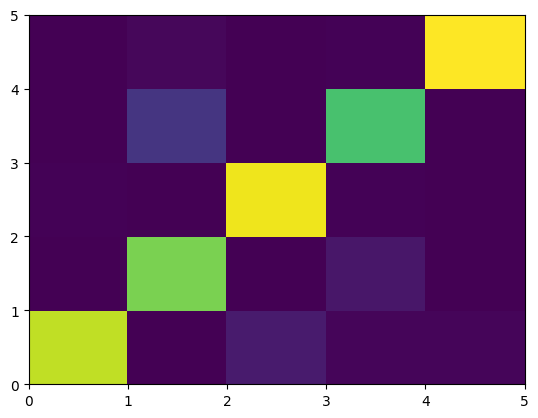

In [ ]:
model=setup_pretrained_model(f32weights)
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])
y_pred = [probability_model(a[None,:,:]) for a in x_test]
plt.pcolor(sms.confusion_matrix(y_test,np.array(y_pred).squeeze().argmax(axis=1)))

up


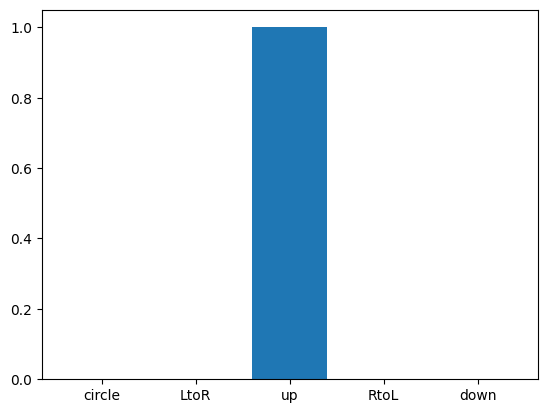

In [ ]:
X=90
plt.bar(classes,probability_model(x_test[X][None,:,:]).numpy().squeeze())
print(classes[y_test[X]])

In [ ]:
x_train_quantized,x_test_quantized = (np.array([x[1] for x in data_sets_list[:int(len(data_sets_list)*0.8)]])).astype(np.uint8) ,(np.array([x[1] for x in data_sets_list[int(len(data_sets_list)*0.8):]])).astype(np.uint8)
def representative_dataset():
    for i in range(len(x_train)):
        yield({'input_input':x_train[i].astype(np.float32)})

In [ ]:
_quant_model=setup_model()
_quant_model.load_weights(f32weights)
converter_tflite=tf.lite.TFLiteConverter.from_keras_model(_quant_model)
converter_tflite.optimizations = [tf.lite.Optimize.DEFAULT]

converter_tflite.representative_dataset = representative_dataset
converter_tflite.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter_tflite.inference_input_type = tf.uint8  # or tf.uint8
converter_tflite.inference_output_type = tf.int8  # or tf.uint8
converter_tflite.experimental_new_converter = True
tflite_quant_model = converter_tflite.convert()
tf.lite.experimental.Analyzer.analyze(model_content=tflite_quant_model)

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


=== TFLite ModelAnalyzer ===

Your TFLite model has '1' subgraph(s). In the subgraph description below,
T# represents the Tensor numbers. For example, in Subgraph#0, the QUANTIZE op takes
tensor #0 as input and produces tensor #8 as output.

Subgraph#0 main(T#0) -> [T#12]
  Op#0 QUANTIZE(T#0) -> [T#8]
  Op#1 RESHAPE(T#8, T#1[-1, 135]) -> [T#9]
  Op#2 FULLY_CONNECTED(T#9, T#7, T#6[-57, -30, -93, -62, -28, ...]) -> [T#10]
  Op#3 FULLY_CONNECTED(T#10, T#5, T#4[-79, -5, -57, 32, -12, ...]) -> [T#11]
  Op#4 FULLY_CONNECTED(T#11, T#3, T#2[-443, -163, 505, -24, 240]) -> [T#12]

Tensors of Subgraph#0
  T#0(serving_default_input_input:0) shape_signature:[-1, 27, 5], type:UINT8
  T#1(sequential_4/input/Const) shape:[2], type:INT32 RO 8 bytes, buffer: 2, data:[-1, 135]
  T#2(sequential_4/dense_11/BiasAdd/ReadVariableOp) shape:[5], type:INT32 RO 20 bytes, buffer: 3, data:[-443, -163, 505, -24, 240]
  T#3(sequential_4/dense_11/MatMul) shape:[5, 50], type:INT8 RO 250 bytes, buffer: 4, data:[0, ., .,

In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_quant_model)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)
print(output_details)

[{'name': 'serving_default_input_input:0', 'index': 0, 'shape': array([ 1, 27,  5], dtype=int32), 'shape_signature': array([-1, 27,  5], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.6705882549285889, 0), 'quantization_parameters': {'scales': array([0.67058825], dtype=float32), 'zero_points': array([0], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall:0', 'index': 12, 'shape': array([1, 5], dtype=int32), 'shape_signature': array([-1,  5], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.5985912680625916, -60), 'quantization_parameters': {'scales': array([0.59859127], dtype=float32), 'zero_points': array([-60], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [ ]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
X=14

# 入力層のテンソルデータ構成の取得
input_shape = input_details[0]['shape']
print(input_shape,(x_test_quantized[1]).astype(np.int8).shape)
# テンソルデータ構成から、ランダムな ndArrayを作成
# np.arrayのcall時に、input_detailsのdtypeと整合性が取れるように型をセットしないと、set_tensor時にエラーが発生
input_data = np.expand_dims((x_test_quantized[X]),0).astype(np.uint8)
# indexにテンソルデータのポインタをセット
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()
# 推論結果は、output_detailsのindexに保存されている
output_data = interpreter.get_tensor(output_details[0]['index'])
print(y_test[X])
print(output_data)

[ 1 27  5] (27, 5)
4
[[-51 -57 -49 -57 -42]]


0.9225


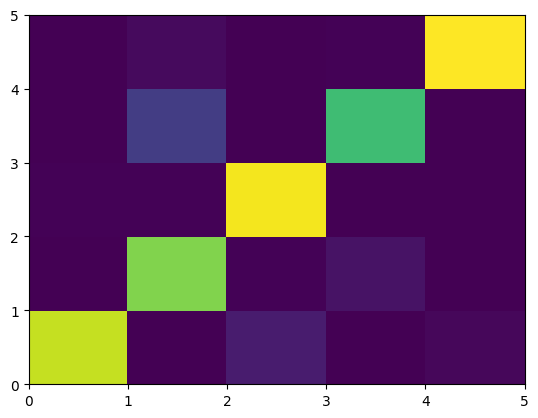

In [ ]:
y_pred_quantized = []
for datas in x_test_quantized:
  interpreter.set_tensor(input_details[0]['index'], np.expand_dims(datas,0).astype(np.uint8))
  interpreter.invoke()
  y_pred_quantized.append(interpreter.get_tensor(output_details[0]['index']).squeeze().argmax())
plt.pcolor(sms.confusion_matrix(y_test,y_pred_quantized))
print(sms.accuracy_score(y_test,y_pred_quantized))

In [ ]:
print(x_test_quantized[X],y_train[5])

[[  0 152 150   0   0]
 [  0 147 146   0   0]
 [  0 137 102   0   0]
 [  0 127 121   0   0]
 [ 12 118 116   0   0]
 [  0 103 108   0   0]
 [  0  90  94   0   0]
 [  0  55  91   0   0]
 [ 12   0  67   0   0]
 [  0   1  27   0   0]
 [  0   0   0   0  31]
 [  0   0   0   0   0]
 [ 12   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0  58   0   0]
 [  0   4   0   0   4]
 [  0  52  15   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0  30]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  0  25  28   0   0]
 [  0   0   0   0  39]
 [ 12   0   0   0  39]
 [  0   0   0   0   0]
 [  0  58   0   0   0]
 [  0   0   0   0  10]] 4


In [ ]:
open("/content/drive/MyDrive/hack_u/converted_model2.tflite", "wb").write(tflite_quant_model)

12728

In [ ]:
!xxd -i /content/drive/MyDrive/hack_u/converted_model2.tflite > /content/drive/MyDrive/hack_u/model_data.h